# Initialize system

In [1]:
### Setup the library ###
import pyrogue as pr
import os, sys
import matplotlib.pyplot as plt
import time
import datetime
import numpy as np
import math
import pprint
import inspect 
top_level=f'{os.getcwd()}/../'
rootTopLevel = top_level+'script/'
pr.addLibraryPath( rootTopLevel )

import setupLibPaths

import ePix320kM as devBoard

args = None

In [2]:
# ONLY RUN ONCE!
# Defining root
root =  devBoard.Root(   
        top_level  = rootTopLevel,
        dev        = '/dev/datadev_1',
        pollEn     = False,
        initRead   = True,
        serverPort = 9099)
root.start()

# example showing a read
AxiVersion = root.Core.AxiVersion
print ( '###################################################')
print ( '#             Firmware Version                    #')
print ( '###################################################')
AxiVersion.printStatus()
print ( '###################################################')

{'name': 'ScopeData0'}
{'name': 'ScopeData1'}
{'name': 'ScopeData2'}
{'name': 'ScopeData3'}
Root.Core.Si5345Pll.Page0.DataBlock.setPollInterval(1)
Start: Started zmqServer on ports 9099-9101
    To start a gui: python -m pyrogue gui --server='localhost:9099'
    To use a virtual client: client = pyrogue.interfaces.VirtualClient(addr='localhost', port=9099)
Root.Core.AxiVersion count reset called
###################################################
#             Firmware Version                    #
###################################################
Path         = Root.Core.AxiVersion
FwVersion    = 0x1000300
UpTime       = 21:41:52
GitHash      = 0x9550c2a95f7e334393e52bfde914e26fb20f11b8
XilinxDnaId  = 0x400200000139d7204c81a145
FwTarget     = ePixHRM320k
BuildEnv     = Vivado v2023.1
BuildServer  = rdsrv314 (Ubuntu 20.04.6 LTS)
BuildDate    = Wed 17 Jan 2024 11:42:17 PM PST
Builder      = dnajjar
###################################################


In [3]:
# Useful short names
APP  = root.App
AXIV = root.Core.AxiVersion
ASICTOP = APP.AsicTop
TRIG = ASICTOP.TriggerRegisters
ASIC0 = APP.Mv2Asic[0]
ASIC1 = APP.Mv2Asic[1]
ASIC2 = APP.Mv2Asic[2]
ASIC3 = APP.Mv2Asic[3]
HSDAC = APP.Dac.FastDac 
PKREG0 = ASICTOP.DigAsicStrmRegisters0
PKREG1 = ASICTOP.DigAsicStrmRegisters1
PKREG2 = ASICTOP.DigAsicStrmRegisters2
PKREG3 = ASICTOP.DigAsicStrmRegisters3
BATCHER0 = ASICTOP.BatcherEventBuilder0
BATCHER1 = ASICTOP.BatcherEventBuilder1
BATCHER2 = ASICTOP.BatcherEventBuilder2
BATCHER3 = ASICTOP.BatcherEventBuilder3
DEBUG0 = root._dbg[0]
DEBUG1 = root._dbg[1]
DEBUG2 = root._dbg[2]
DEBUG3 = root._dbg[3]
DATARCV0 = root.DataReceiver0
DATARCV1 = root.DataReceiver1
DATARCV2 = root.DataReceiver2
DATARCV3 = root.DataReceiver3
FULLRATERCV0 = root.fullRateDataReceiver[0]
FULLRATERCV1 = root.fullRateDataReceiver[1]
FULLRATERCV2 = root.fullRateDataReceiver[2]
FULLRATERCV3 = root.fullRateDataReceiver[3]
DAC = APP.Dac
REGCTRL = ASICTOP.RegisterControlDualClock

In [4]:
# Configure clock to 168 MHz and configures all ASICS
root.InitASIC([4,1,1,1,1])

Rysync ASIC started
Init ASIC script started
Loading PLL configuration
Loading supply configuration
Loading /u1/lorenzor/epix-hr-m-320k/software/notebook/../script/../config/ePixHRM320k_PowerSupply_Enable.yml
Loading lane delay configurations
Loading /u1/lorenzor/epix-hr-m-320k/software/notebook/../script/../config/ePixHRM320k_SspMonGrp_carrier3.yml
Loading waveforms configuration
Loading /u1/lorenzor/epix-hr-m-320k/software/notebook/../script/../config/ePixHRM320k_RegisterControl.yml
Loading packet register configurations
Loading /u1/lorenzor/epix-hr-m-320k/software/notebook/../script/../config/ePixHRM320k_PacketRegisters.yml
Loading batcher configurations
Loading /u1/lorenzor/epix-hr-m-320k/software/notebook/../script/../config/ePixHRM320k_BatcherEventBuilder.yml
Taking asic off of reset
Loading ASICs and timing configuration
Loading /u1/lorenzor/epix-hr-m-320k/software/notebook/../script/../config/ePixHRM320k_ASIC_u1_PLLBypass.yml
Loading /u1/lorenzor/epix-hr-m-320k/software/noteboo

In [5]:
root.disableAndCleanAllFullRateDataRcv()
root.enableDataRcv(False)
root.enableDataDebug(False)

In [6]:
#run some triggers and exercise lanes and locks
frames = 100
rate = 5000

root.hwTrigger(frames, rate)

Stop Triggers command executed
Set Auto Trigger command executed
Start Auto Trigger command executed
Triggers sent: 100
Stop Triggers command executed


In [7]:
#get locked lanes
time.sleep(3)
root.getLaneLocks()

ASIC0: 0xffffff
ASIC1: 0xfffffa
ASIC2: 0xb6ffff
ASIC3: 0xbfffff


In [8]:
#Disabled lanes in ASICS
for asicIndex in range(4) : 
    root.App.AsicTop.DigAsicStrmRegisters0.enable.set(True)
    print("ASIC{}: {:#x}".format(asicIndex, getattr(root.App.AsicTop, f"DigAsicStrmRegisters{asicIndex}").DisableLane.get()))

ASIC0: 0x20000
ASIC1: 0x10045
ASIC2: 0x490000
ASIC3: 0x540140


In [9]:
#Enable data receivers and run some triggers
root.enableDataRcv(True)
root.enableAllAsics(True)
for i in range (5):
    root.Trigger()

descramble error
rawData length 12840
descramble error
rawData length 6264
descramble error
rawData length 18840
descramble error
rawData length 12840


In [10]:
# Obtain descrambled single frame data from ASICs from DataReceiver. Data receiver is down sampled.
root.printDataReceiverStatus()
    
frame = [None for i in range(4)]
for asicIndex in range(4):
    frame[asicIndex] = getattr(root, f"DataReceiver{asicIndex}").Data.get()

Checkpoint: DataReceiver 0 has 1 frames
Checkpoint: DataReceiver 1 has 1 frames
Checkpoint: DataReceiver 2 has 1 frames
Checkpoint: DataReceiver 3 has 1 frames


# Here we select which ASIC we want to test

In [11]:
# Change these 3 lines when you want to select another ASIC
AsicNum = 1
dataDebug = DEBUG1
ASIC = ASIC1

# From here it's all the same
root.enableAllAsics(False)
root.enableAsic(AsicNum, True)
root.enableDataRcv(False)

dataDebug.enableDataDebug(True) ##### -- This was changed !!!
dataDebug.cleanData() ##### -- This was changed !!!

# Lorenzo - Helper functions

In [12]:
%run dataProcFunctions.ipynb     #this is were my function was stored

In [13]:
# helper functions
# clock speed is 168MHz. 1 tick is 0.006 us
def setSR0(width, delay) :
    REGCTRL.SR0Delay1.set(delay)
    REGCTRL.SR0Width1.set(width)
    print(f'SR0 Width set to {REGCTRL.SR0Width1_us.get():.3f}uS')
    print(f'SR0 Delay set to {REGCTRL.SR0Delay_us.get():.3f}uS')
    
def setAcq1(width, delay) :
    REGCTRL.AcqDelay1.set(delay)
    REGCTRL.AcqWidth1.set(width)
    print(f'Acq1 Width set to {REGCTRL.AcqWidth1_us.get():.3f}uS')
    print(f'Acq1 Delay set to {REGCTRL.AcqDelay1_us.get():.3f}uS')
    
def setAcq2(width, delay) :
    REGCTRL.AcqDelay2.set(delay)
    REGCTRL.AcqWidth2.set(width)
    print(f'Acq2 Width set to {REGCTRL.AcqWidth2_us.get():.3f}uS')
    print(f'Acq2 Delay set to {REGCTRL.AcqDelay2_us.get():.3f}uS')    

def setR0(width, delay) :
    REGCTRL.R0Delay.set(delay)
    REGCTRL.R0Width.set(width)
    print(f'R0 Width set to {REGCTRL.R0Width_us.get():.3f}uS')
    print(f'R0 Delay set to {REGCTRL.R0Delay_us.get():.3f}uS') 

    
def setSync(width, delay) :
    REGCTRL.SyncDelay.set(delay)
    REGCTRL.SyncWidth.set(width)
    print(f'Sync Delay set to {REGCTRL.SyncDelay_us.get():.3f}uS')     

# Set registers and variables

In [14]:
# ADC settings
ASIC.DHg.set(True)    # Set High gain
ASIC.S2D_1_b.set(0)   # Set bias current to max (min value)
ASIC.Ref_gen_d.set(2) # Set 'common-mode' voltage of S/H stage
ASIC.RefGenB.set(2)   # Don't touch
ASIC.mTest.set(False)      # Don't touch


ASIC.pipoclk_delay_row0.set(7)
ASIC.pipoclk_delay_row1.set(8)
ASIC.pipoclk_delay_row2.set(8)
ASIC.pipoclk_delay_row3.set(8)

# Set some registers...
ASIC.CompTH_ePixM.set(0)

# Define integration time
setR0(420, 200)
setAcq1(160, 360)
setSR0(38000, 700)

baseline_int_time = REGCTRL.AcqDelay1_us.get() - REGCTRL.R0Delay_us.get()
integration_time = REGCTRL.AcqWidth1_us.get()
print(f'Baseline time:    {baseline_int_time} uS')
print(f'Integration time: {integration_time} uS')
print(f'-------------------------')

# Optimal bias settings
ASIC.RefinN.set(4)
ASIC.RefinP.set(4)

# Reference pixel
ref_row = 100
ref_col = 150


R0 Width set to 2.688uS
R0 Delay set to 1.280uS
Acq1 Width set to 1.024uS
Acq1 Delay set to 2.304uS
SR0 Width set to 226.190uS
SR0 Delay set to 4.167uS
Baseline time:    1.0239999999999998 uS
Integration time: 1.024 uS
-------------------------


--- Acquiring data value 0/0 ---
Data Descrambled
(192, 384, 1)
14728.0
Data Descrambled
(192, 384, 1)
12767.0
Data Descrambled
(192, 384, 1)
10503.0
Data Descrambled
(192, 384, 1)
7958.0
Data Descrambled
(192, 384, 100)
--- Acquiring data value 0/1 ---
Data Descrambled
(192, 384, 1)
14672.0
Data Descrambled
(192, 384, 1)
12322.0
Data Descrambled
(192, 384, 1)
9692.0
Data Descrambled
(192, 384, 1)
7190.0
Data Descrambled
(192, 384, 100)
--- Acquiring data value 0/2 ---
Data Descrambled
(192, 384, 1)
14480.0
Data Descrambled
(192, 384, 1)
12176.0
Data Descrambled
(192, 384, 1)
9698.0
Data Descrambled
(192, 384, 1)
6443.0
Data Descrambled
(192, 384, 100)
--- Acquiring data value 0/3 ---
Data Descrambled
(192, 384, 1)
14704.0
Data Descrambled
(192, 384, 1)
12289.0
Data Descrambled
(192, 384, 1)
9256.0
Data Descrambled
(192, 384, 1)
6727.0
Data Descrambled
(192, 384, 100)
--- Acquiring data value 0/4 ---
Data Descrambled
(192, 384, 1)
14921.0
Data Descrambled
(192, 384, 1)
12178.0
Data Des

Data Descrambled
(192, 384, 1)
10238.0
Data Descrambled
(192, 384, 1)
7327.0
Data Descrambled
(192, 384, 1)
4735.0
Data Descrambled
(192, 384, 100)
--- Acquiring data value 5/3 ---
Data Descrambled
(192, 384, 1)
13066.0
Data Descrambled
(192, 384, 1)
10209.0
Data Descrambled
(192, 384, 1)
7032.0
Data Descrambled
(192, 384, 1)
4737.0
Data Descrambled
(192, 384, 100)
--- Acquiring data value 5/4 ---
Data Descrambled
(192, 384, 1)
13207.0
Data Descrambled
(192, 384, 1)
10108.0
Data Descrambled
(192, 384, 1)
7344.0
Data Descrambled
(192, 384, 1)
4562.0
Data Descrambled
(192, 384, 100)
--- Acquiring data value 5/5 ---
Data Descrambled
(192, 384, 1)
13442.0
Data Descrambled
(192, 384, 1)
10603.0
Data Descrambled
(192, 384, 1)
7616.0
Data Descrambled
(192, 384, 1)
4908.0
Data Descrambled
(192, 384, 100)
--- Acquiring data value 5/6 ---
Data Descrambled
(192, 384, 1)
13755.0
Data Descrambled
(192, 384, 1)
11217.0
Data Descrambled
(192, 384, 1)
8484.0
Data Descrambled
(192, 384, 1)
5267.0
Data 

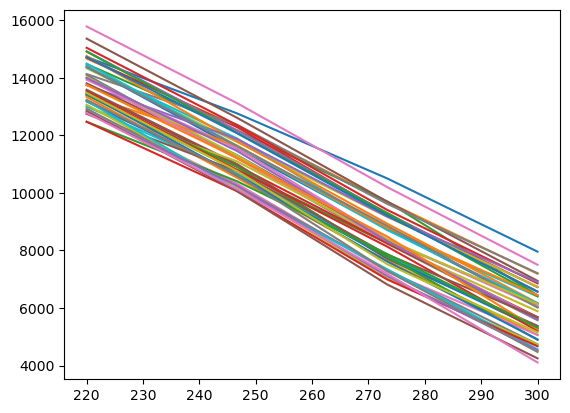

In [15]:
# Define empty arrays

noise   = np.empty([8,8])
gain    = np.empty([8,8])

for RefN_val, RefP_val in np.ndindex(7,7):
    print('--- Acquiring data value {}/{} ---'.format(RefN_val,RefP_val))
    ASIC.RefinN.set(RefN_val)
    ASIC.RefinP.set(RefP_val)
    # Get ramps and calculate gain
    ChInjValues, pixelRamp = chargeInjRamp(dataDebug,AsicNum=AsicNum,Min=220, Max=300, numSteps=4)
    plt.plot(ChInjValues, pixelRamp)
    gain[RefN_val,RefP_val] = np.polyfit(ChInjValues, pixelRamp, 1)[0]
    
    # Get darks and calculate noise
    data = readoutFrames(dataDebug, 100)
    data_noisemap = np.std(data, axis=2)    
    noise[RefN_val,RefP_val] = np.median(data_noisemap)

[[47.08166836 58.49074243 68.75373262 76.0531048  83.53937365 89.46495124]
 [47.32716979 59.10026226 69.20356746 76.66619692 84.15450255 90.10758431]
 [47.34846882 59.34176059 69.90002217 77.2269642  84.76719118 90.84189424]
 [47.59566681 59.61364189 70.25995836 77.98742911 85.39629237 91.48046567]
 [47.95166681 59.78674433 70.55756444 78.29848529 85.95793128 91.98012937]
 [48.29247871 60.07060429 70.87280684 78.47400174 86.24987391 92.18557452]]
[[ -84.6525   -94.035    -99.70875 -101.115   -104.85    -105.65625]
 [ -88.20375  -95.24625 -101.45625 -104.41125 -107.3625  -106.1475 ]
 [ -87.10875  -97.4175  -100.5225  -107.14875 -103.02375 -104.78625]
 [ -89.03625  -96.615    -98.6775  -102.70125 -104.835   -104.565  ]
 [ -87.3825   -97.64625  -99.64875 -103.9125  -107.6475  -103.44375]
 [ -90.41625  -99.3525  -103.065   -105.615   -107.62125 -107.20875]]


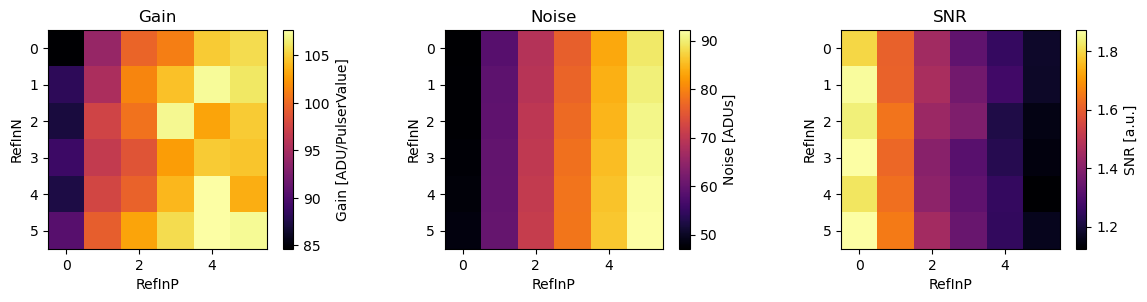

Recommended setting RefN/RefP:(array([5]), array([0]))


In [17]:
noise = noise[0:6,0:6]  
gain = gain[0:6,0:6]    

print(noise)
print(gain)

snr = abs(gain)/noise

# Create the subplots
fig, axes = plt.subplots(1, 3, figsize=(12, 3))

# Plot the images on each subplot
im1 = axes[0].imshow(abs(gain), cmap='inferno')
im2 = axes[1].imshow(noise, cmap='inferno')
im3 = axes[2].imshow(snr, cmap='inferno')

# Set titles for each subplot
axes[0].set_title('Gain')
axes[1].set_title('Noise')
axes[2].set_title('SNR')

axes[0].set_xlabel('RefInP')
axes[1].set_xlabel('RefInP')
axes[2].set_xlabel('RefInP')

axes[0].set_ylabel('RefInN')
axes[1].set_ylabel('RefInN')
axes[2].set_ylabel('RefInN')

# Optionally, display the axes on each subplot
axes[0].axis('on')
axes[1].axis('on')
axes[2].axis('on')

# Add colorbars to each subplot
cbar1 = fig.colorbar(im1, ax=axes[0])
cbar2 = fig.colorbar(im2, ax=axes[1])
cbar3 = fig.colorbar(im3, ax=axes[2])

# Set colorbar labels (optional)
cbar1.set_label('Gain [ADU/PulserValue]')
cbar2.set_label('Noise [ADUs]')
cbar3.set_label('SNR [a.u.]')

# Show the plots
plt.tight_layout()
plt.show()

print('Recommended setting RefN/RefP:{}'.format(np.where(snr == snr.max())))
